In [1]:
pip install joblib tensorflow torch

  Using cached torch-2.5.1-cp310-cp310-win_amd64.whl (203.1 MB)
     -------------------------------------- 183.9/183.9 kB 1.4 MB/s eta 0:00:00
  Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Model prediction: 9.289304733276367


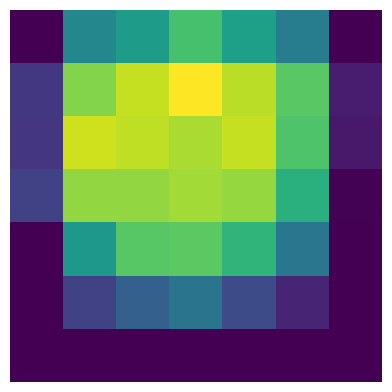

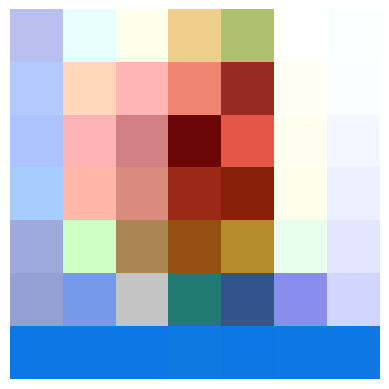

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Loading pre-trained model
model = tf.keras.models.load_model('age_pred_1.h5')

# Function to get the image array
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  
    return img_array

# Function to make Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Creating model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    # Compute the gradients
    grads = tape.gradient(loss, conv_outputs)

    # Pool the gradients over the spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the corresponding gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

# Function to save and display the Grad-CAM heatmap
def save_and_display_gradcam(img_path, heatmap, cam_path='cam.jpg', alpha=0.4):

    img = cv2.imread(img_path)
    img = cv2.resize(img, (heatmap.shape[1], heatmap.shape[0]))

    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # Save the superimposed image
    cv2.imwrite(cam_path, superimposed_img)

 
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Generate Grad-CAM
if __name__ == '__main__':
    img_path = 'happy-beautiful-brunette-woman-long-hair-looking-tooth-toothy-smiling-blue-background-71323182.jpg'
    img_array = get_img_array(img_path, size=(224, 224)) 

    # Define the last convolutional layer name
    last_conv_layer_name = 'Conv_1'  # last convolutional layer is 'Conv_1'
    
    # Generate the Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    prediction = model.predict(img_array)
    print(f"Model prediction: {prediction[0][0]}")

    # Display the heatmap
    plt.matshow(heatmap)
    plt.axis('off')
    plt.show()

    # Display the overlayed image
    save_and_display_gradcam(img_path, heatmap)